# Train and save network for 10K patient subset

## Aims

* To train and save a 1D embedding network for a 10K patient subset. A 10K subset is set aside and a model trained on the remaining 78,792 patients.

## Set up

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2022-06-12 12:36:44.104670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './saved_models/1d_for_10k/'
if not os.path.exists(path):
    os.makedirs(path)

In [4]:
path = './saved_models/1d_for_10k/'

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Set up neural net

In [6]:
def make_net(number_features_patient,
             number_features_pathway,
             number_features_hospital, 
             patient_encoding_neurones=1,
             pathway_encoding_neurones=1,
             hospital_encoding_neurones=1,
             expansion=2, 
             learning_rate=0.003, 
             dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Patient (clinical data) encoding layers
    input_patient = layers.Input(shape=number_features_patient)
    
    # Patient dense layer 1
    patient_dense_1 = layers.Dense(
        number_features_patient * expansion, activation='relu')(input_patient)
    patient_norm_1 = layers.BatchNormalization()(patient_dense_1)
    patient_dropout_1 = layers.Dropout(dropout)(patient_norm_1)
    
    # Patient encoding layer
    patient_encoding = layers.Dense(
        patient_encoding_neurones, activation='sigmoid', 
        name='patient_encode')(patient_dropout_1)
    
    
    # Pathway encoding layers
    input_pathway = layers.Input(shape=number_features_pathway)
    
    # pathway dense layer 1
    pathway_dense_1 = layers.Dense(
        number_features_pathway * expansion, activation='relu')(input_pathway)
    pathway_norm_1 = layers.BatchNormalization()(pathway_dense_1)
    pathway_dropout_1 = layers.Dropout(dropout)(pathway_norm_1)
    
    # pathway encoding layer
    pathway_encoding = layers.Dense(
        pathway_encoding_neurones, activation='sigmoid', 
        name='pathway_encode')(pathway_dropout_1)
    
    
    # hospital encoding layers
    input_hospital = layers.Input(shape=number_features_hospital)
    
    # hospital encoding layer
    hospital_encoding = layers.Dense(
        hospital_encoding_neurones, activation='sigmoid', 
        name='hospital_encode')(input_hospital)    
    
    # Concatenation layer
    concat = layers.Concatenate()(
        [patient_encoding, pathway_encoding, hospital_encoding])
    
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(concat)
    
    # Build net
    net = Model(inputs=[
        input_patient, input_pathway, input_hospital], outputs=outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Train model

Accuracy train 0.857 Accuracy test 0.852


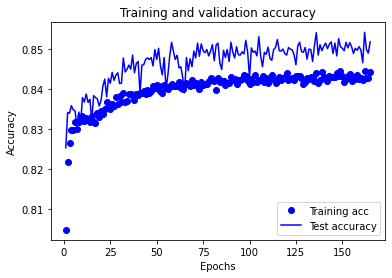

In [7]:
# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)
  
# Load data
train = pd.read_csv(f'../data/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv(f'../data/10k_training_test/cohort_10000_test.csv')

# Limit subgroups to fields present
# Due to improved data selection in this repository
clinical_subgroup = [
    subgroup for subgroup in clinical_subgroup if subgroup in list(train)]
pathway_subgroup = [
    subgroup for subgroup in pathway_subgroup if subgroup in list(train)]

# OneHot encode stroke team
coded = pd.get_dummies(train['StrokeTeam'])
train = pd.concat([train, coded], axis=1)
train.drop('StrokeTeam', inplace=True, axis=1)
coded = pd.get_dummies(test['StrokeTeam'])
test = pd.concat([test, coded], axis=1)
test.drop('StrokeTeam', inplace=True, axis=1)

# Split into X, y
X_train_df = train.drop('S2Thrombolysis',axis=1) 
y_train_df = train['S2Thrombolysis']
X_test_df = test.drop('S2Thrombolysis',axis=1) 
y_test_df = test['S2Thrombolysis'] 

# Split train and test data by subgroups
X_train_patients = X_train_df[clinical_subgroup]
X_test_patients = X_test_df[clinical_subgroup]
X_train_pathway = X_train_df[pathway_subgroup]
X_test_pathway = X_test_df[pathway_subgroup]
X_train_hospitals = X_train_df[hospital_subgroup]
X_test_hospitals = X_test_df[hospital_subgroup]

# Convert to NumPy
X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

# Scale data
X_train_patients_sc, X_test_patients_sc = \
    scale_data(X_train_patients, X_test_patients)

X_train_pathway_sc, X_test_pathway_sc = \
    scale_data(X_train_pathway, X_test_pathway)

X_train_hospitals_sc, X_test_hospitals_sc = \
    scale_data(X_train_hospitals, X_test_hospitals)

# Define network
number_features_patient = X_train_patients_sc.shape[1]
number_features_pathway = X_train_pathway_sc.shape[1]
number_features_hospital = X_train_hospitals_sc.shape[1]

model = make_net(
    number_features_patient, 
    number_features_pathway, 
    number_features_hospital)

# Define early stopping callback: Stop when no validation improvement
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=50, restore_best_weights=True)

# Train model (including class weights)
history = model.fit(
    [X_train_patients_sc, X_train_pathway_sc, X_train_hospitals_sc],
    y_train,
    epochs=5000,
    batch_size=32,
    validation_data=(
        [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc], 
        y_test),
    verbose=0,
    callbacks=[early_stopping_cb])

### Test model
probability = model.predict(
    [X_train_patients_sc, X_train_pathway_sc, X_train_hospitals_sc])
y_pred_train = probability >= 0.5
y_pred_train = y_pred_train.flatten()
accuracy_train = np.mean(y_pred_train == y_train)
print(f'Accuracy train {accuracy_train:0.3f}', end=' ')

probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Accuracy test {accuracy_test:0.3f}')

# save model
filename = f'{path}10k_model.h5'
model.save(filename);

# Plot training accuracy
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Observations

* In the training charts above you will see that test accuracy is higher than training accuracy. This may seem surprising; it is due to keras returning the accuracy of the training set during training when dropout is used (and no dropout is used for the test set).